In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install prophet
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    !pip install sktime
# import matplotlib
# !pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sktime.forecasting.naive import NaiveForecaster
from prophet import Prophet
from neuralprophet import NeuralProphet
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [2]:
SALES_PATH = '/ssd003/projects/forecasting_bootcamp/bootcamp_datasets/m5-forecasting-accuracy/sales_train_evaluation.csv'
CALENDAR_PATH = '/ssd003/projects/forecasting_bootcamp/bootcamp_datasets/m5-forecasting-accuracy/calendar.csv'
PRICES_PATH = '/ssd003/projects/forecasting_bootcamp/bootcamp_datasets/m5-forecasting-accuracy/sell_prices.csv'

In [3]:
# data_filename = "/content/drive/MyDrive/Vector's/forecasting/data/drive-download-20221025T173415Z-001/m5-forecasting-accuracy/sales_train_evaluation.csv"
data_df = pd.read_csv(SALES_PATH)
# data_filename = "/content/drive/MyDrive/Vector's/forecasting/data/drive-download-20221025T173415Z-001/m5-forecasting-accuracy/sell_prices.csv"
sell_data = pd.read_csv(PRICES_PATH)
# data_filename = "/content/drive/MyDrive/Vector's/forecasting/data/drive-download-20221025T173415Z-001/m5-forecasting-accuracy/calendar.csv"
calendar_data = pd.read_csv(CALENDAR_PATH)

In [4]:
# DATA_SERIES  = pd.melt(data_df, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name  =['d'],value_name ="Sales")
DATA_SERIES  = pd.melt(data_df, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name  =['d'])
cal_merge = DATA_SERIES.merge(calendar_data,on=["d"],copy = True)

In [7]:
DATA_SERIES.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'value'],
      dtype='object')

In [17]:
pd.pivot_table(final_merge.head(2000), values='value', index=['date'],
                    columns=['store_id'], aggfunc=np.sum)

store_id,CA_1
date,
2011-01-29,743
2011-01-30,690
2011-01-31,581
2011-02-01,548
2011-02-02,379
2011-02-03,619
2011-02-04,488


In [12]:
DATA_SERIES['id'].nunique(),DATA_SERIES['item_id'].nunique(),DATA_SERIES['dept_id'].nunique(),DATA_SERIES['cat_id'].nunique(),DATA_SERIES['store_id'].nunique(),DATA_SERIES['state_id'].nunique(),
# DATA_SERIES['state_id'].nunique()

(30490, 3049, 7, 3, 10, 3)

In [5]:
final_merge = cal_merge.merge(sell_data,on=['store_id', 'item_id', 'wm_yr_wk'],copy=False)
final_merge["sold_total"] = final_merge["value"] * final_merge["sell_price"]

In [9]:
final_pivot = pd.pivot_table(final_merge.groupby(["date","store_id"])["sold_total"].sum().reset_index(), values='sold_total', index=['date'],
                    columns=['store_id'])

In [35]:
final_pivot.index

Index(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01', '2011-02-02',
       '2011-02-03', '2011-02-04', '2011-02-05', '2011-02-06', '2011-02-07',
       ...
       '2016-05-13', '2016-05-14', '2016-05-15', '2016-05-16', '2016-05-17',
       '2016-05-18', '2016-05-19', '2016-05-20', '2016-05-21', '2016-05-22'],
      dtype='object', length=1941)

In [6]:
final_merge_agg = final_merge.groupby("date")["sold_total"].sum().reset_index()

In [27]:
final_pivot.columns.name = None
final_pivot.index.name = None
final_pivot.columns = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2',
       'WI_3']

In [43]:
final_pivot.columns
# final_pivot.drop(columns=["date1"],inplace=True)

Index(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2',
       'WI_3', 'date'],
      dtype='object')

In [44]:
final_pivot.head()

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,date
2011-01-29,10933.16,9101.52,11679.83,4561.59,6586.68,9915.78,7597.99,6454.72,5451.46,9367.88,2011-01-29
2011-01-30,9787.06,8417.53,12161.46,4681.41,6610.60,9804.54,7356.54,5645.77,4636.86,9868.80,2011-01-30
2011-01-31,7201.38,5320.51,9123.86,3637.98,4551.97,6651.16,5406.70,3640.12,4621.58,7551.65,2011-01-31
2011-02-01,7407.74,5550.56,10249.78,3708.92,5374.39,6985.60,5597.97,2949.96,5754.75,7181.53,2011-02-01
2011-02-02,6566.12,5229.72,9538.65,3841.14,4347.07,6039.05,4069.74,2.96,2679.19,4646.31,2011-02-02


In [81]:
final_pivot["date"].agg(["min","max"])

min    2011-01-29
max    2016-05-22
Name: date, dtype: object

In [18]:
final_merge.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'value', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'sold_total'],
      dtype='object')

# Split the Data

In [8]:
lag_time = 90
lead_time = 60

train_size = 0.8

train_df = final_merge_agg.iloc[:int(len(final_merge_agg)*train_size)]
test_df = final_merge_agg.iloc[int(len(final_merge_agg)*train_size):]

In [9]:
train_df.shape,test_df.shape

((1552, 2), (389, 2))

In [23]:
test_df.columns

Index(['date', 'sold_total'], dtype='object')

In [13]:
class ForecastingDataset:

    def __init__(self, data_df, lag_time, lead_time, feature_columns):
        self.n_examples = len(data_df) - lag_time - lead_time + 1
        assert self.n_examples > 0, "Dataset must contain at least one example."
        assert "date" in data_df.columns or "ds" in data_df.columns, "Source DataFrame must contain a date/ds column."

        self.df = data_df[feature_columns]
        if 'date' in data_df.columns:
            self.dates = data_df.date
        elif 'ds' in data_df.columns:
            self.dates = data_df.ds
        self.lag_time = lag_time
        self.lead_time = lead_time

    def __len__(self):
        return self.n_examples

    def __getitem__(self, idx):
        input = self.df.iloc[idx:idx+lag_time]
        output = self.df.iloc[idx+lag_time:idx+lag_time+lead_time]
        input_dates = self.dates[idx:idx+lag_time]
        output_dates = self.dates[idx+lag_time:idx+lag_time+lead_time]
        return input, output, input_dates, output_dates

In [11]:
feature_columns = ['sold_total']
test_dataset = ForecastingDataset(test_df, lag_time, lead_time, feature_columns)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

metrics = {
    'mse': mean_squared_error,
    'rmse': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error
}

def compute_error_statistics(error_metrics_dict, exp_name):
    return {
        'mean': pd.DataFrame(error_metrics_dict).mean(axis=0).rename(f'{exp_name}_mean_metrics'),
        'std': pd.DataFrame(error_metrics_dict).std(axis=0).rename(f'{exp_name}_std_metrics'),
        'max': pd.DataFrame(error_metrics_dict).max(axis=0).rename(f'{exp_name}_max_metrics'),
    }

# Neural Prophet
## Details : https://github.com/ourownstory/neural_prophet

In [13]:
np_train_df = train_df.reset_index().rename({'date':'ds', 'sold_total':'y'}, axis=1).drop('index', axis=1)
np_test_df = test_df.reset_index().rename({'date':'ds','sold_total':'y'}, axis=1).drop('index', axis=1)

In [15]:
np_train_df

,ds,y
0,2011-01-29,81650.61
1,2011-01-30,78970.57
2,2011-01-31,57706.91
3,2011-02-01,60761.20
4,2011-02-02,46959.95
...,...,...
1547,2015-04-25,136837.46
1548,2015-04-26,136222.47
1549,2015-04-27,105241.67
1550,2015-04-28,92166.61


## Baseline Default Neural Prephet

In [46]:
np_model = NeuralProphet(n_lags=lag_time, n_forecasts=lead_time)

# Add the non-target feature columns as lagged regressors
feature_cols = [col for col in np_train_df if col not in ('USD_CLOSE', 'ds', 'y')]
for feature in feature_cols:
    np_model.add_lagged_regressor(f'{feature}')
    
np_model.fit(np_train_df, freq='D')

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 162


  0%|          | 0/257 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.69E-03, min: 1.96E-01


  0%|          | 0/257 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.69E-03, min: 1.96E-01


  0%|          | 0/257 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.69E-03, min: 1.96E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.69E-03
Epoch[162/162]: 100%|██████████| 162/162 [00:27<00:00,  5.98it/s, SmoothL1Loss=0.00282, MAE=7.02e+3, RMSE=9.75e+3, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,1.366358,236850.547777,279676.726724,0.0
1,1.317871,230303.542142,272527.248307,0.0
2,1.259373,222384.390859,263885.044180,0.0
3,1.185566,212330.740556,252950.717358,0.0
4,1.094974,199910.042298,239484.917153,0.0
...,...,...,...,...
157,0.002822,7026.716148,9757.869235,0.0
158,0.002821,7025.141749,9761.756512,0.0
159,0.002820,7024.268158,9759.589408,0.0
160,0.002820,7024.019916,9760.563672,0.0


In [64]:
feature_cols

[]

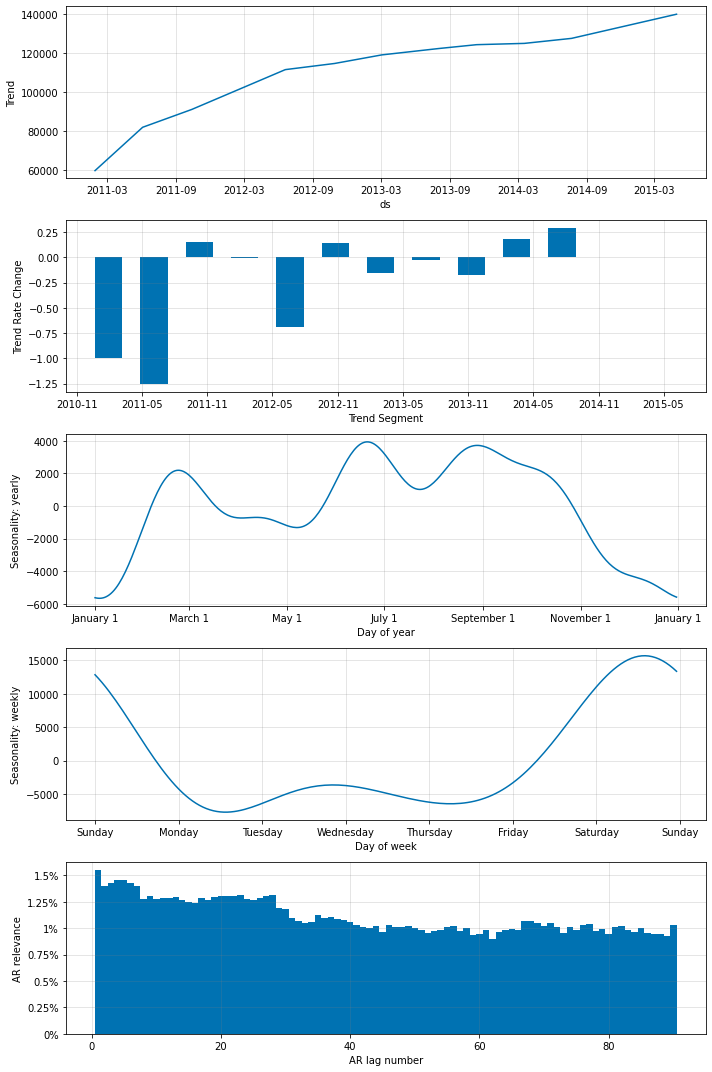

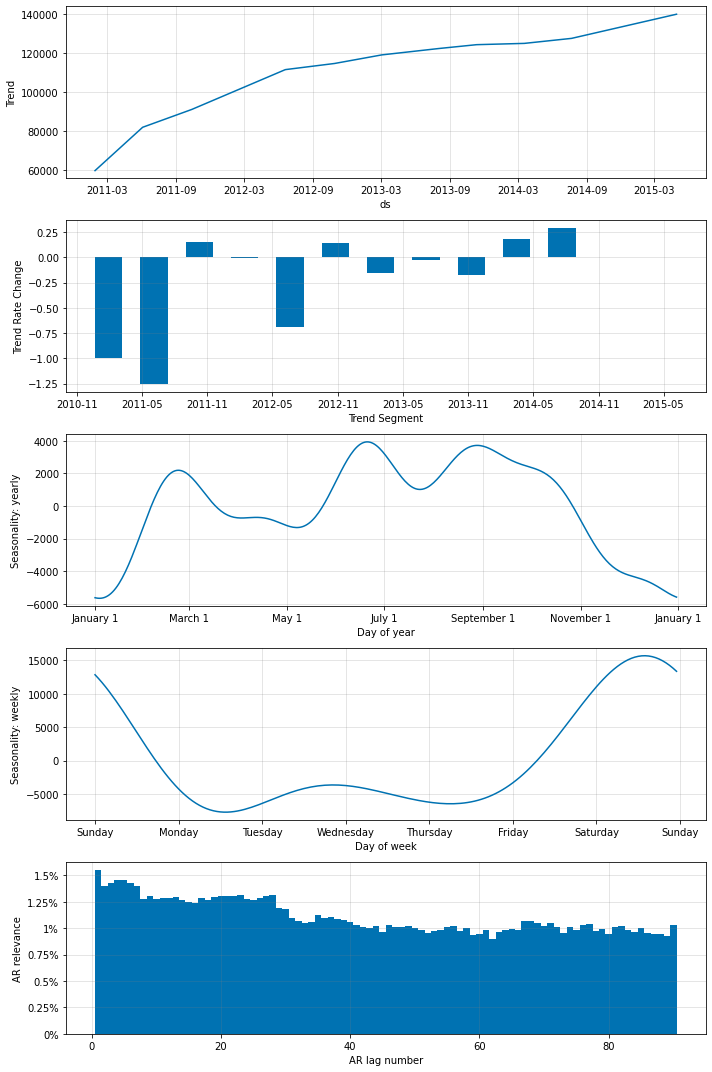

In [17]:
np_model.plot_parameters()

In [47]:
np_test_df

,ds,y
0,2015-04-30,94389.67
1,2015-05-01,124224.94
2,2015-05-02,141390.17
3,2015-05-03,154247.38
4,2015-05-04,118548.40
...,...,...
384,2016-05-18,116333.11
385,2016-05-19,117456.32
386,2016-05-20,134000.67
387,2016-05-21,162395.65


In [48]:
x, y, x_d, y_d = test_dataset[0]
x = x.reset_index().rename({'date':'ds', 'sold_total':'y'}, axis=1).drop('index', axis=1)
x = x.assign(ds=x_d.reset_index().drop('index', axis=1).values)
y = y.reset_index().rename({'date':'ds', 'sold_total':'y'}, axis=1).drop('index', axis=1)

np_future_df = np_model.make_future_dataframe(x, periods=len(y))
np_forecast = np_model.predict(np_future_df, decompose=False, raw=True)
np_forecast

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities


,ds,step0,step1,step2,step3,step4,step5,step6,step7,step8,...,step50,step51,step52,step53,step54,step55,step56,step57,step58,step59
0,2015-07-29,103825.179688,110748.625,106401.164062,139217.765625,152913.421875,122184.726562,112212.210938,112505.109375,120214.867188,...,111057.4375,112850.03125,143364.0,149821.640625,109381.867188,102231.164062,109303.5,103134.226562,116546.898438,135508.640625


In [15]:
def yhat_from_neuralprophet_forecast(np_forecast, y_d):
    return pd.Series(np_forecast.T.iloc[1:].set_index(y_d).iloc[:,0], name='np_yhat').rename_axis('ds')

In [16]:
def collect_np_forecasts(np_model, test_dataset):

    forecasts = []

    for i in range(len(test_dataset)):
        
        x, y, x_d, y_d = test_dataset[i]
        x = x.reset_index().rename({'date':'ds', 'sold_total':'y'}, axis=1).drop('index', axis=1)
        x = x.assign(ds=x_d.reset_index().drop('index', axis=1).values)
        y = y.reset_index().rename({'date':'ds', 'sold_total':'y'}, axis=1).drop('index', axis=1)

        np_future_df = np_model.make_future_dataframe(x, periods=len(y))
        np_forecast = np_model.predict(np_future_df, decompose=False, raw=True)
        fc_series = yhat_from_neuralprophet_forecast(np_forecast, y_d)
        forecasts.append(fc_series)

    return forecasts

In [17]:
def compute_np_error_metrics(forecasts):

    errors = {metric_name:[] for metric_name in metrics.keys()}

    for i in range(len(forecasts)):
        
        fc = forecasts[i]
        gt = test_df.loc[test_df.date.isin(fc.index)].sort_values('date')  # Sorting because I am not 100% sure that the 'isin' function always preserves order.
        
        for metric_name, metric_fn in metrics.items(): 
                errors[metric_name].append(metric_fn(y_true=gt['sold_total'], y_pred=fc))

    return errors, forecasts

In [51]:
forecasts = collect_np_forecasts(np_model, test_dataset)
np_baseline_error_metrics, fcs = compute_np_error_metrics(forecasts)

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

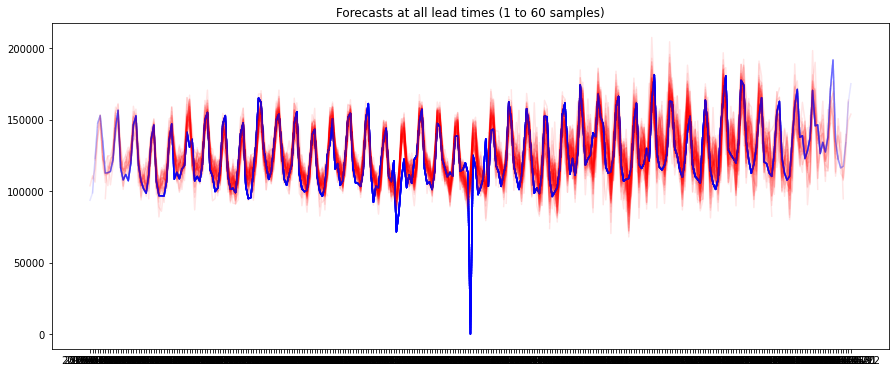

In [52]:
fig, ax = plt.subplots(figsize=(15,6))

for i in range(len(forecasts)):

    fc = forecasts[i]
    gt = test_df.loc[test_df.date.isin(fc.index)]

    ax.plot(fc.index[:], fc[:], alpha=0.1, color='red')
    ax.plot(gt.date, gt['sold_total'], alpha=0.1, color='blue')
plt.title(f"Forecasts at all lead times (1 to {lead_time} samples)")
plt.show()

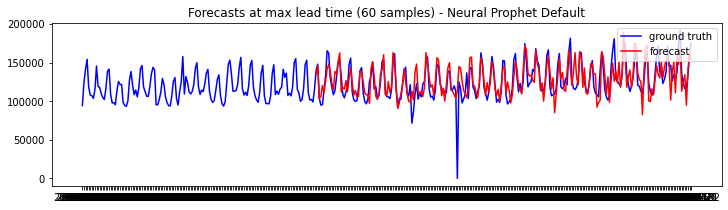

In [53]:
max_fcs = [{'date': fc.index[-1:][0], 'yhat':fc[-1:][0]} for fc in forecasts]
max_fcs = pd.DataFrame(max_fcs)

plt.figure(figsize=(12,3))
plt.plot(test_df.date, test_df['sold_total'], color='blue', label='ground truth')
plt.plot(max_fcs.date, max_fcs.yhat, color='red', label='forecast')
plt.title(f"Forecasts at max lead time ({lead_time} samples) - Neural Prophet Default")
plt.legend(loc='upper right')

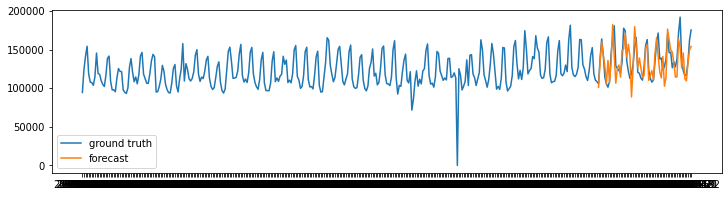

In [54]:
# Plot ground truth
plt.figure(figsize=(12,3))
ground_truth = test_df[['date', 'sold_total']]
plt.plot(ground_truth.date, ground_truth['sold_total'], label='ground truth')

# Plot example single forecast
plt.plot(forecasts[-1], label='forecast')
plt.legend()

In [55]:
compute_error_statistics(np_baseline_error_metrics, 'neural_prophet_baseline')

{'mean': mse     2.238547e+08
 rmse    1.453619e+04
 mae     1.071659e+04
 mape    1.471036e+01
 Name: neural_prophet_baseline_mean_metrics, dtype: float64,
 'std': mse     1.008550e+08
 rmse    3.550526e+03
 mae     2.232667e+03
 mape    2.542424e+01
 Name: neural_prophet_baseline_std_metrics, dtype: float64,
 'max': mse     4.112066e+08
 rmse    2.027823e+04
 mae     1.478090e+04
 mape    6.390309e+01
 Name: neural_prophet_baseline_max_metrics, dtype: float64}

In [56]:
results_df = pd.DataFrame(compute_error_statistics(np_baseline_error_metrics, 'neural_prophet_baseline')["mean"]).T

In [57]:
results_df

,mse,rmse,mae,mape
neural_prophet_baseline_mean_metrics,2.238547e+08,14536.194597,10716.594794,14.710359


## Restricted model

In [58]:
np_model_last_sample_only = NeuralProphet(n_lags=lag_time, n_forecasts=lead_time)

# Add the non-target feature columns as lagged regressors
feature_cols = [col for col in np_train_df if col not in ('USD_CLOSE', 'ds', 'y')]
for feature in feature_cols:
    np_model_last_sample_only.add_lagged_regressor(f'{feature}',only_last_value=True)
    
np_model_last_sample_only.fit(np_train_df, freq='D')
forecasts = collect_np_forecasts(np_model_last_sample_only, test_dataset)
np_last_sample_only_error_metrics, fcs = compute_np_error_metrics(forecasts)

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 162


  0%|          | 0/257 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.72E-03, min: 3.75E-01


  0%|          | 0/257 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.72E-03, min: 3.46E-01


  0%|          | 0/257 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.72E-03, min: 3.75E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.72E-03
Epoch[162/162]: 100%|██████████| 162/162 [00:25<00:00,  6.28it/s, SmoothL1Loss=0.0029, MAE=7.2e+3, RMSE=9.9e+3, RegLoss=0]   
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts ar

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

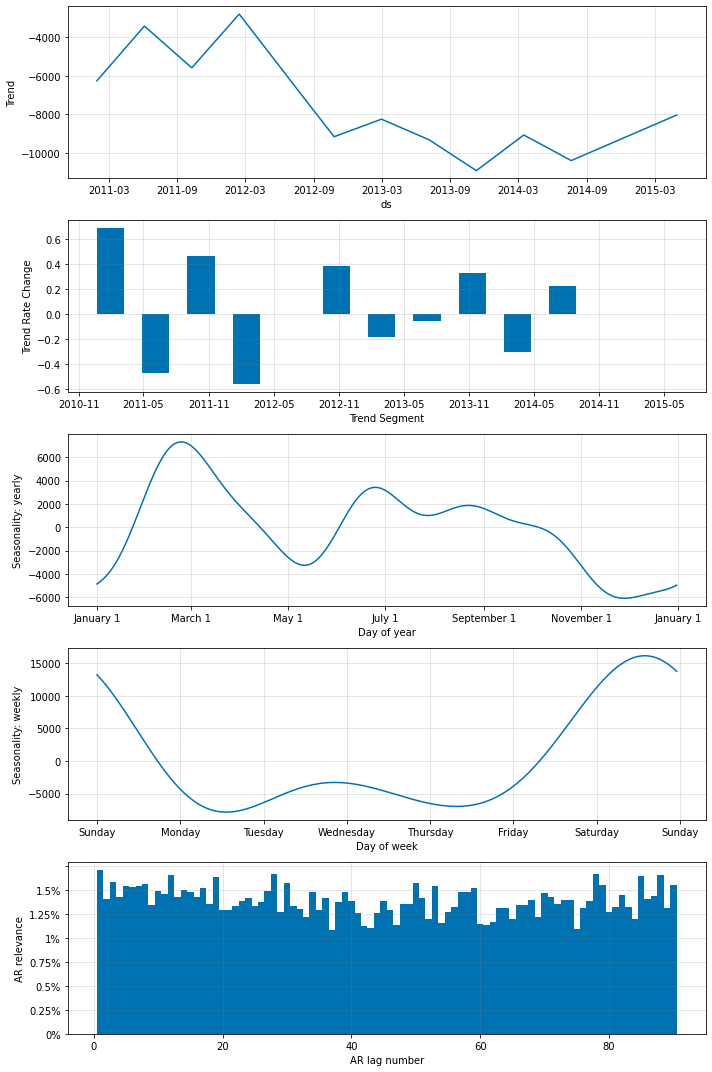

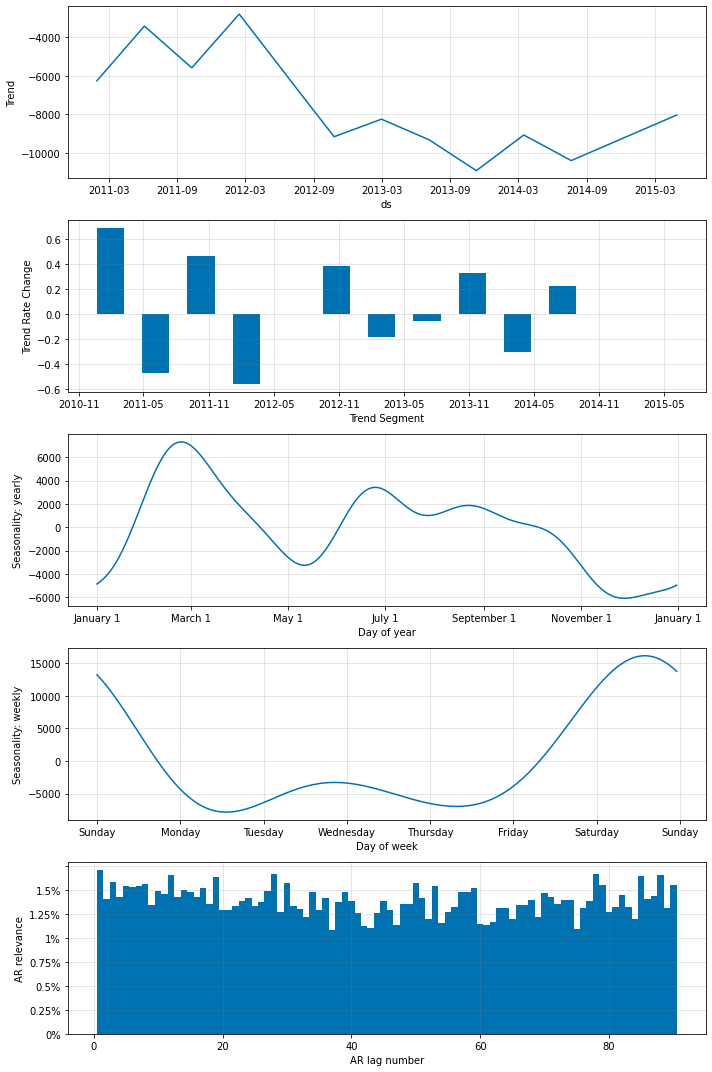

In [34]:
np_model_last_sample_only.plot_parameters()

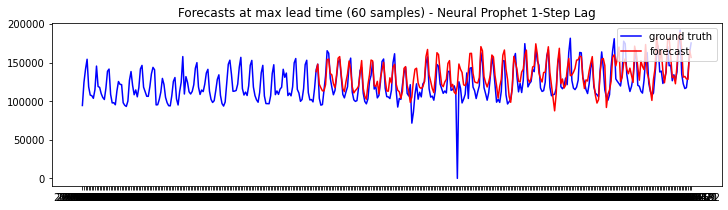

In [59]:
max_fcs = [{'date': fc.index[-1:][0], 'yhat':fc[-1:][0]} for fc in forecasts]
max_fcs = pd.DataFrame(max_fcs)

plt.figure(figsize=(12,3))
plt.plot(test_df.date, test_df['sold_total'], color='blue', label='ground truth')
plt.plot(max_fcs.date, max_fcs.yhat, color='red', label='forecast')
plt.title(f"Forecasts at max lead time ({lead_time} samples) - Neural Prophet 1-Step Lag")
plt.legend(loc='upper right')

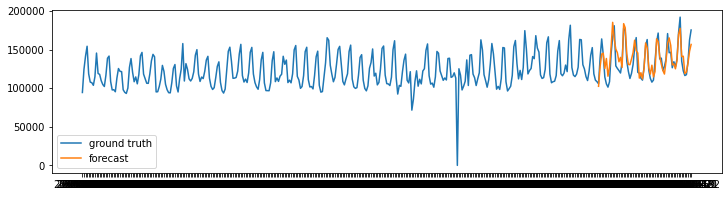

In [60]:
# Plot ground truth
plt.figure(figsize=(12,3))
ground_truth = test_df[['date', 'sold_total']]
plt.plot(ground_truth.date, ground_truth['sold_total'], label='ground truth')

# Plot example single forecast
plt.plot(forecasts[-1], label='forecast')
plt.legend()

In [62]:
results_df = results_df.append(compute_error_statistics(np_last_sample_only_error_metrics, 'neural_prophet_last_sample_only')['mean'])
results_df.sort_values('mae')

,mse,rmse,mae,mape
neural_prophet_baseline_mean_metrics,2.238547e+08,14536.194597,10716.594794,14.710359
neural_prophet_last_sample_only_mean_metrics,2.669196e+08,15838.363946,12014.910286,16.353532


# With Stores_ID level forecast
## Hierarchical based Forecast

In [45]:
lag_time = 90
lead_time = 60

train_size = 0.8

train_df = final_pivot.iloc[:int(len(final_pivot)*train_size)]
test_df = final_pivot.iloc[int(len(final_pivot)*train_size):]

In [30]:
train_df.shape,test_df.shape

((1552, 10), (389, 10))

In [46]:
test_df.columns

Index(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2',
       'WI_3', 'date'],
      dtype='object')

In [49]:
feature_columns = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
test_dataset = ForecastingDataset(test_df, lag_time, lead_time, feature_columns)

In [52]:
np_train_df

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,ds
0,10933.16,9101.52,11679.83,4561.59,6586.68,9915.78,7597.99,6454.72,5451.46,9367.88,2011-01-29
1,9787.06,8417.53,12161.46,4681.41,6610.60,9804.54,7356.54,5645.77,4636.86,9868.80,2011-01-30
2,7201.38,5320.51,9123.86,3637.98,4551.97,6651.16,5406.70,3640.12,4621.58,7551.65,2011-01-31
3,7407.74,5550.56,10249.78,3708.92,5374.39,6985.60,5597.97,2949.96,5754.75,7181.53,2011-02-01
4,6566.12,5229.72,9538.65,3841.14,4347.07,6039.05,4069.74,2.96,2679.19,4646.31,2011-02-02
...,...,...,...,...,...,...,...,...,...,...,...
1547,19511.84,10786.45,22832.82,8013.05,11186.85,14294.89,13536.50,15064.94,11857.74,9752.38,2015-04-25
1548,18082.28,9619.36,24343.67,9104.42,12242.24,14464.91,14248.66,12784.24,11245.83,10086.86,2015-04-26
1549,12253.32,7582.82,18236.87,8357.97,8880.18,11167.28,12760.58,8994.72,9639.06,7368.87,2015-04-27
1550,11299.98,6306.32,16965.70,7168.45,8204.97,9473.44,10449.47,7567.70,8384.61,6345.97,2015-04-28


In [53]:
np_train_df = train_df.reset_index().rename({'date':'ds', 'CA_1':'y'}, axis=1).drop('index', axis=1)
np_test_df = test_df.reset_index().rename({'date':'ds','CA_1':'y'}, axis=1).drop('index', axis=1)

In [57]:
np_model = NeuralProphet(n_lags=lag_time, n_forecasts=lead_time)

# Add the non-target feature columns as lagged regressors
feature_cols = [col for col in np_train_df if col not in ('CA_1', 'ds', 'y')]
for feature in feature_cols:
    np_model.add_lagged_regressor(f'{feature}')
    
np_model.fit(np_train_df, freq='D')

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 162


  0%|          | 0/257 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.91E-04, min: 3.05E-02


  0%|          | 0/257 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.91E-04, min: 3.31E-02


  0%|          | 0/257 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.91E-04, min: 3.31E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.91E-04
Epoch[162/162]: 100%|██████████| 162/162 [00:46<00:00,  3.52it/s, SmoothL1Loss=0.0302, MAE=3.26e+3, RMSE=4.14e+3, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,2.340454,47124.135772,60181.124543,0.0
1,2.246320,45507.263348,58475.927683,0.0
2,2.134669,43587.713026,56394.013119,0.0
3,1.996654,41212.927374,53716.790719,0.0
4,1.830228,38340.640603,50331.400083,0.0
...,...,...,...,...
157,0.030251,3265.233096,4139.342504,0.0
158,0.030246,3265.029357,4139.261890,0.0
159,0.030241,3264.694792,4139.293316,0.0
160,0.030238,3264.530546,4138.940684,0.0


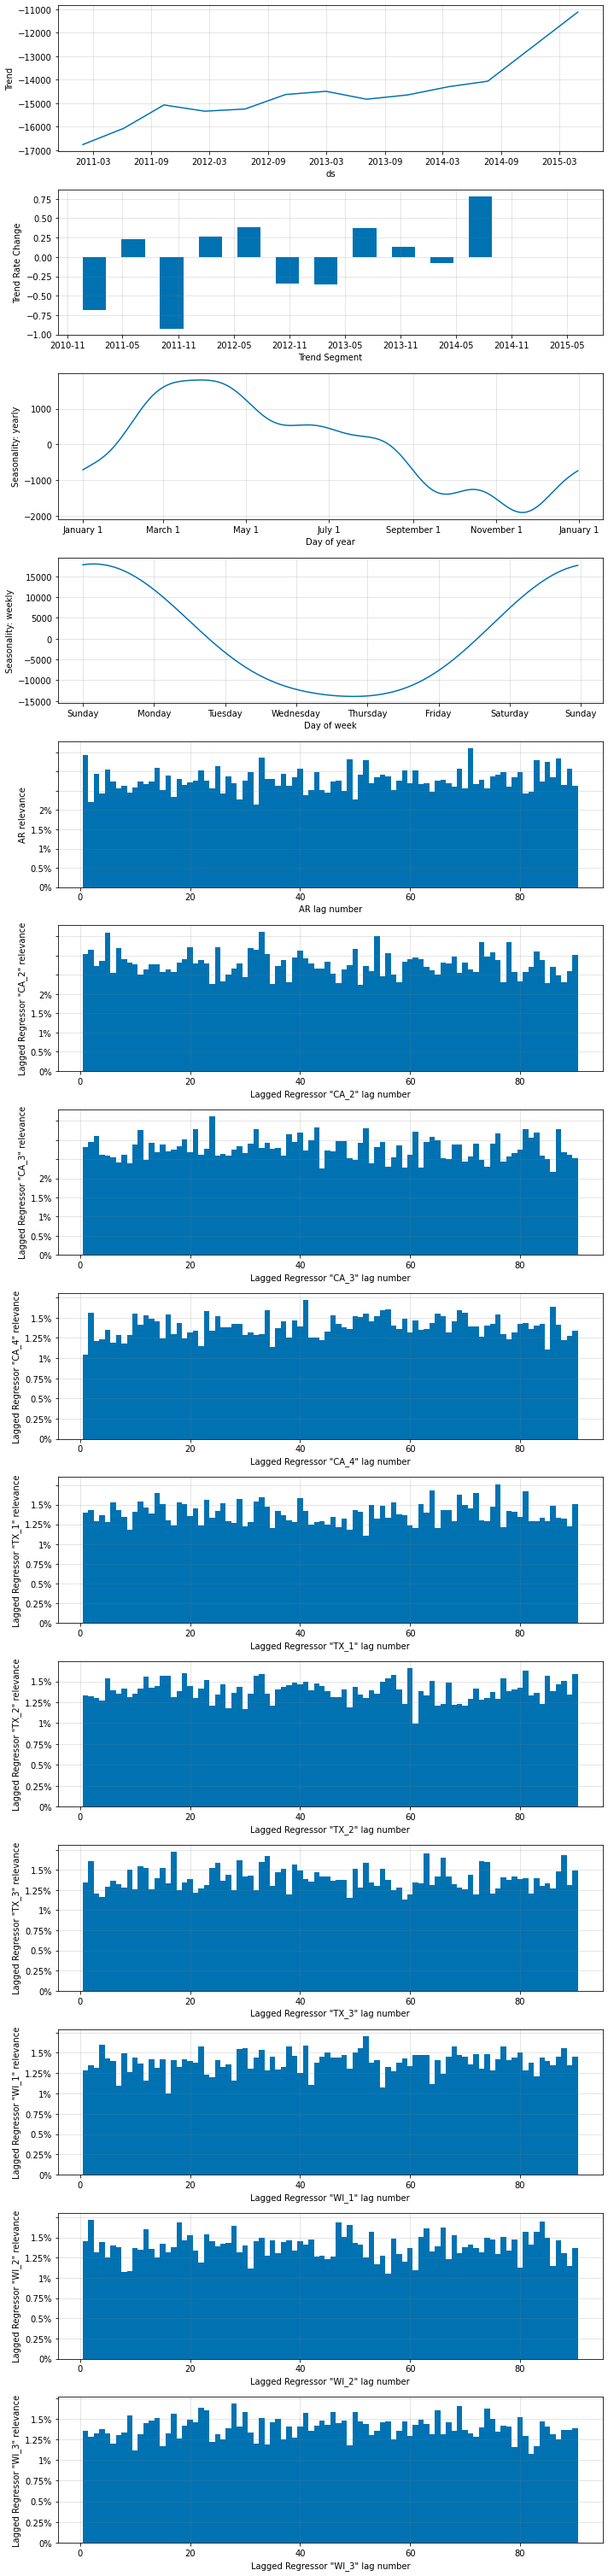

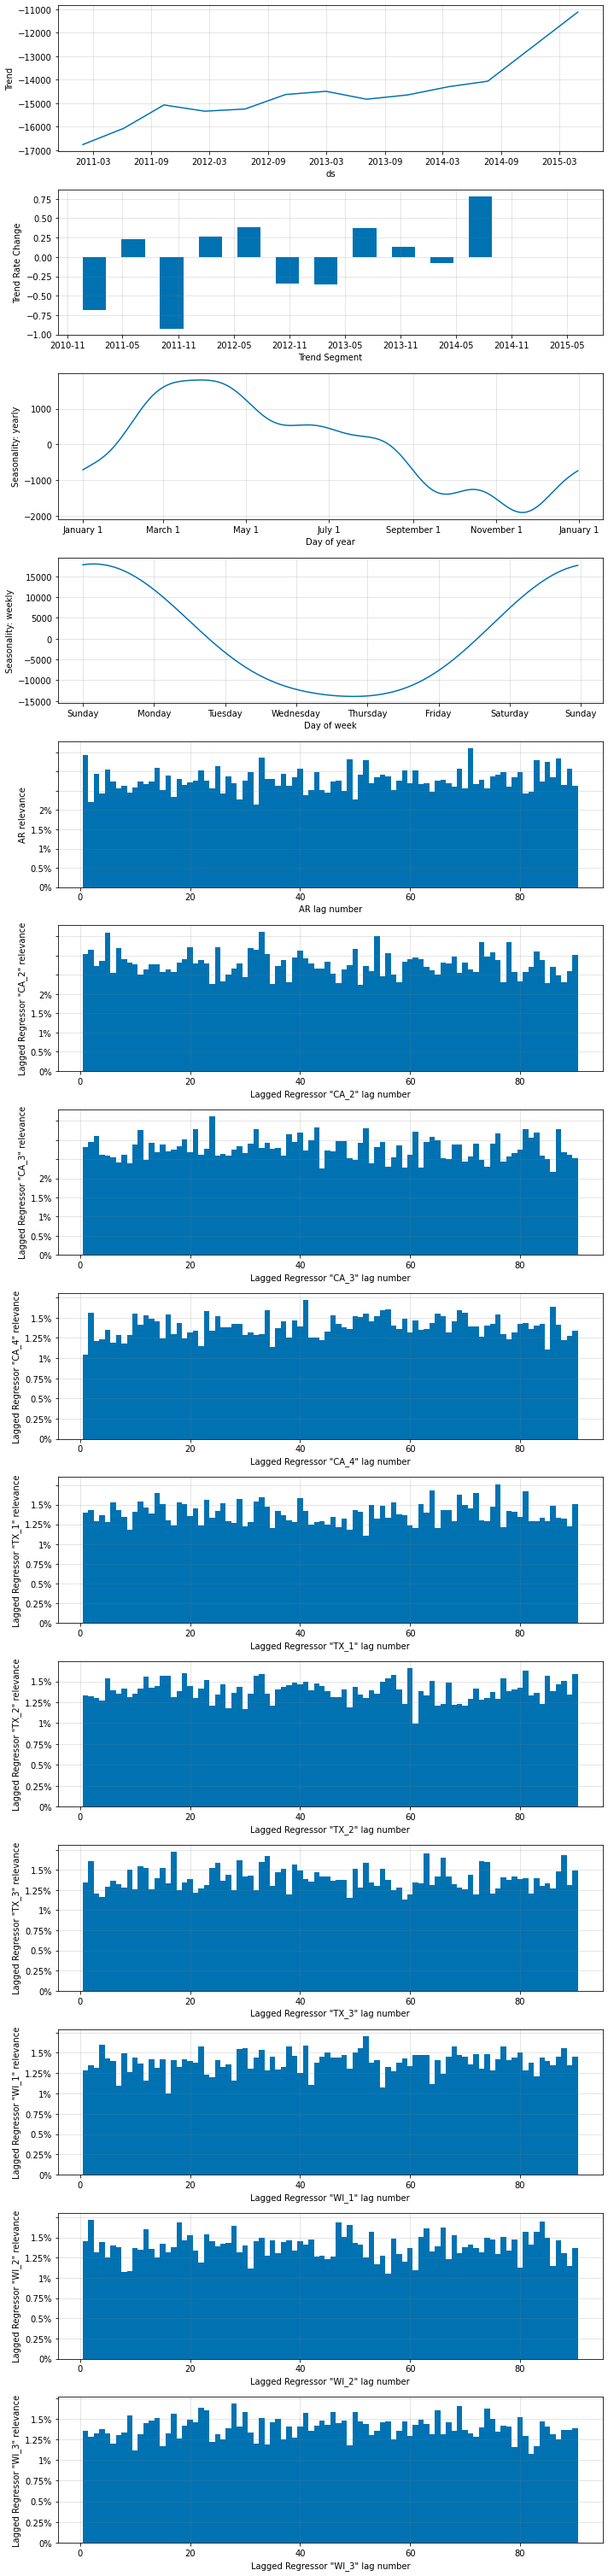

In [58]:
np_model.plot_parameters()

In [59]:
x, y, x_d, y_d = test_dataset[0]
x = x.reset_index().rename({'date':'ds', 'CA_1':'y'}, axis=1).drop('index', axis=1)
x = x.assign(ds=x_d.reset_index().drop('index', axis=1).values)
y = y.reset_index().rename({'date':'ds', 'CA_1':'y'}, axis=1).drop('index', axis=1)

np_future_df = np_model.make_future_dataframe(x, periods=len(y))
np_forecast = np_model.predict(np_future_df, decompose=False, raw=True)
np_forecast

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities


,ds,step0,step1,step2,step3,step4,step5,step6,step7,step8,...,step50,step51,step52,step53,step54,step55,step56,step57,step58,step59
0,2015-07-29,31899.34375,18792.269531,14718.347656,31662.427734,19889.644531,21176.517578,15614.575195,25075.226562,21952.410156,...,28095.056641,21907.371094,24099.916016,28230.175781,21555.779297,11464.035156,24038.150391,5835.072266,32258.068359,29410.380859


In [60]:
def yhat_from_neuralprophet_forecast(np_forecast, y_d):
    return pd.Series(np_forecast.T.iloc[1:].set_index(y_d).iloc[:,0], name='np_yhat').rename_axis('ds')

In [64]:
def collect_np_forecasts(np_model, test_dataset):

    forecasts = []

    for i in range(len(test_dataset)):
        
        x, y, x_d, y_d = test_dataset[i]
        x = x.reset_index().rename({'date':'ds', 'CA_1':'y'}, axis=1).drop('index', axis=1)
        x = x.assign(ds=x_d.reset_index().drop('index', axis=1).values)
        y = y.reset_index().rename({'date':'ds', 'CA_1':'y'}, axis=1).drop('index', axis=1)

        np_future_df = np_model.make_future_dataframe(x, periods=len(y))
        np_forecast = np_model.predict(np_future_df, decompose=False, raw=True)
        fc_series = yhat_from_neuralprophet_forecast(np_forecast, y_d)
        forecasts.append(fc_series)

    return forecasts

In [65]:
def compute_np_error_metrics(forecasts):

    errors = {metric_name:[] for metric_name in metrics.keys()}

    for i in range(len(forecasts)):
        
        fc = forecasts[i]
        gt = test_df.loc[test_df.date.isin(fc.index)].sort_values('date')  # Sorting because I am not 100% sure that the 'isin' function always preserves order.
        
        for metric_name, metric_fn in metrics.items(): 
                errors[metric_name].append(metric_fn(y_true=gt['CA_1'], y_pred=fc))

    return errors, forecasts

In [66]:
forecasts = collect_np_forecasts(np_model, test_dataset)
np_baseline_error_metrics, fcs = compute_np_error_metrics(forecasts)

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

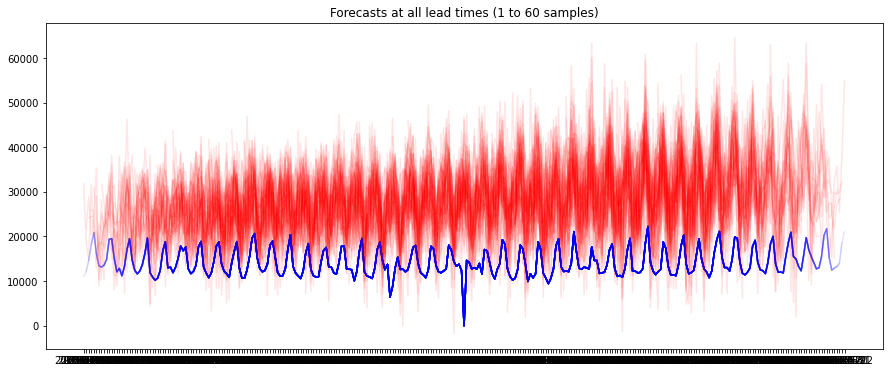

In [68]:
fig, ax = plt.subplots(figsize=(15,6))

for i in range(len(forecasts)):

    fc = forecasts[i]
    gt = test_df.loc[test_df.date.isin(fc.index)]

    ax.plot(fc.index[:], fc[:], alpha=0.1, color='red')
    ax.plot(gt.date, gt['CA_1'], alpha=0.1, color='blue')
plt.title(f"Forecasts at all lead times (1 to {lead_time} samples)")
plt.show()

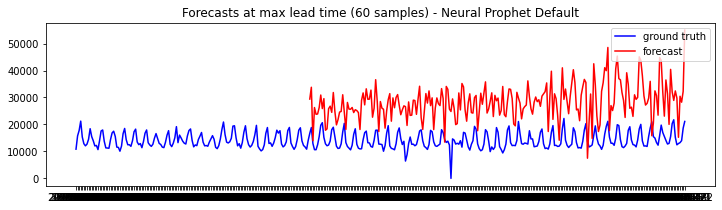

In [69]:
max_fcs = [{'date': fc.index[-1:][0], 'yhat':fc[-1:][0]} for fc in forecasts]
max_fcs = pd.DataFrame(max_fcs)

plt.figure(figsize=(12,3))
plt.plot(test_df.date, test_df['CA_1'], color='blue', label='ground truth')
plt.plot(max_fcs.date, max_fcs.yhat, color='red', label='forecast')
plt.title(f"Forecasts at max lead time ({lead_time} samples) - Neural Prophet Default")
plt.legend(loc='upper right')

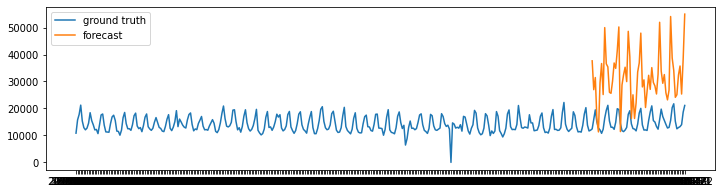

In [70]:
# Plot ground truth
plt.figure(figsize=(12,3))
ground_truth = test_df[['date', 'CA_1']]
plt.plot(ground_truth.date, ground_truth['CA_1'], label='ground truth')

# Plot example single forecast
plt.plot(forecasts[-1], label='forecast')
plt.legend()

In [71]:
results_df = pd.DataFrame(compute_error_statistics(np_baseline_error_metrics, 'neural_prophet_baseline')["mean"]).T

## Restricted Model with State_id level

In [76]:
np_model_last_sample_only = NeuralProphet(n_lags=lag_time, n_forecasts=lead_time)

# Add the non-target feature columns as lagged regressors
feature_cols = [col for col in np_train_df if col not in ('CA_1', 'ds', 'y')]
for feature in feature_cols:
    np_model_last_sample_only.add_lagged_regressor(f'{feature}',only_last_value=True)
    
np_model_last_sample_only.fit(np_train_df, freq='D')
forecasts = collect_np_forecasts(np_model_last_sample_only, test_dataset)
np_last_sample_only_error_metrics, fcs = compute_np_error_metrics(forecasts)

INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 162


  0%|          | 0/257 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.37E-03, min: 2.31E-01


  0%|          | 0/257 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.37E-03, min: 2.71E-01


  0%|          | 0/257 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.03E-03, min: 2.31E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.26E-03
Epoch[162/162]: 100%|██████████| 162/162 [00:40<00:00,  3.97it/s, SmoothL1Loss=0.00796, MAE=1.56e+3, RMSE=2.12e+3, RegLoss=0]
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts ar

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities
WARNING - (NP.forecaster.predict) - raw forecasts are incompatible with plotting utilities

In [74]:
np_model_last_sample_only.plot_parameters()

['CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']

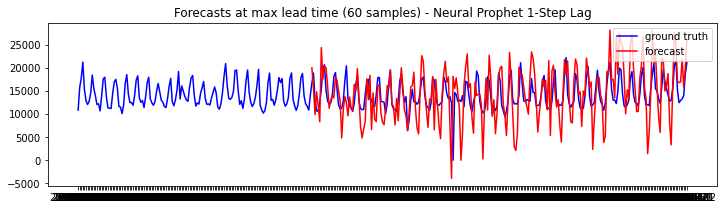

In [80]:
max_fcs = [{'date': fc.index[-1:][0], 'yhat':fc[-1:][0]} for fc in forecasts]
max_fcs = pd.DataFrame(max_fcs)

plt.figure(figsize=(12,3))
plt.plot(test_df.date, test_df['CA_1'], color='blue', label='ground truth')
plt.plot(max_fcs.date, max_fcs.yhat, color='red', label='forecast')
plt.title(f"Forecasts at max lead time ({lead_time} samples) - Neural Prophet 1-Step Lag")
plt.legend(loc='upper right')

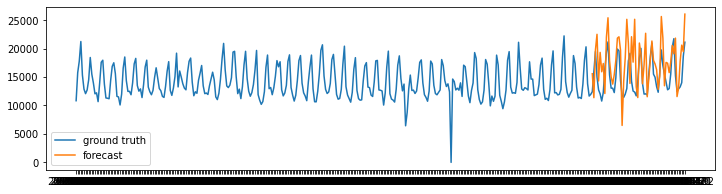

In [78]:
# Plot ground truth
plt.figure(figsize=(12,3))
ground_truth = test_df[['date', 'CA_1']]
plt.plot(ground_truth.date, ground_truth['CA_1'], label='ground truth')

# Plot example single forecast
plt.plot(forecasts[-1], label='forecast')
plt.legend()

In [79]:
results_df = results_df.append(compute_error_statistics(np_last_sample_only_error_metrics, 'neural_prophet_last_sample_only')['mean'])
results_df.sort_values('mae')

,mse,rmse,mae,mape
neural_prophet_last_sample_only_mean_metrics,2.647238e+07,5002.697951,3891.714832,2.709231e+17
neural_prophet_baseline_mean_metrics,2.540279e+08,15783.221403,14090.107100,5.788355e+17


# Cross Validation

In [82]:
cutoff_dates = pd.read_csv(f"{data_dir}/cutoff_dates.txt", sep='\n', header=None)[0].to_list()
cutoff_dates

NameError: name 'data_dir' is not defined

In [92]:
cutoff_dates = ['2011-07-01',
 '2012-07-01',
 '2013-07-01',
 '2014-07-01',
 '2015-07-01']

In [93]:
lag_time = 90
lead_time = 60

train_size = 0.8

train_df = final_pivot.iloc[:int(len(final_pivot)*train_size)]
test_df = final_pivot.iloc[int(len(final_pivot)*train_size):]

In [94]:
sim_train_dates = {}
sim_valid_dates = {}

for date in cutoff_dates:
    sim_train_dates[date] = final_pivot.index[final_pivot.index.astype("date") <= date]
    sim_valid_dates[date] = final_pivot.index[(final_pivot.index > date) & (final_pivot.index <= (pd.to_datetime(date) + pd.DateOffset(months=18)))]

TypeError: '<=' not supported between instances of 'str' and 'Timestamp'

In [95]:
train_df["date"].agg(["min","max"])

min    2011-01-29
max    2015-04-29
Name: date, dtype: object

In [85]:
train_df.columns

Index(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2',
       'WI_3', 'date'],
      dtype='object')

In [88]:
train_df['CA_1']

2011-01-29    10933.16
2011-01-30     9787.06
2011-01-31     7201.38
2011-02-01     7407.74
2011-02-02     6566.12
                ...   
2015-04-25    19511.84
2015-04-26    18082.28
2015-04-27    12253.32
2015-04-28    11299.98
2015-04-29    10596.73
Name: CA_1, Length: 1552, dtype: float64

In [89]:
def get_prophet_df(df, store_id):
    df = df[store_id]
    df = df.reset_index()
    df = df.rename({'REF_DATE':'ds', 'index':'ds', store_id:'y'}, axis=1)
    return df

In [90]:
def fit_eval_forecast_model(store_id, train_df, test_df):
    train_df = get_prophet_df(train_df, store_id)     # Select training data.
    model = Prophet()                                                       # Initialize model with (default) paramters.
    model.fit(train_df)                                                     # Fit the model.
    valid_df = get_prophet_df(test_df, store_id)     # Select the validation data. 
    valid_forecast = model.predict(valid_df[['ds']])                        # Produce the validation period forecast. 

    valid_metrics = {metric_name: metric_fn(y_true=valid_df.y,              # Compute validation metrics. 
                                      y_pred=valid_forecast.yhat) for metric_name, metric_fn in metrics.items()}

    return model, valid_forecast, valid_metrics

In [99]:
def plot_valid_forecast(model, food_category, valid_forecast, valid_actual):

    fig = model.plot(valid_forecast, figsize=(10,4))
    ax = fig.axes[0]
    ax.scatter(valid_actual.ds, valid_actual.y, color='green', s=10, label='Actual CPI')
    ax.set_title(f'CPI Forecast (Simulated From {date}) - {food_category}')
    ax.set_ylabel('CPI (% of 2002 Baseline)')
    ax.set_xlabel('Date')

    ### Creating legend elements
    cmap = plt.get_cmap("tab10")
    handles, labels = ax.get_legend_handles_labels()
    actual_patch = Line2D([0], [0], color='w', markerfacecolor='black', marker='o', label='Historical CPI')
    fc_patch = mpatches.Patch(color=cmap(0), label='Predicted CPI Uncertainty', alpha=0.5)
    fc_line = Line2D([0], [0], color=cmap(0), label='Predicted CPI')
    handles.append(actual_patch)
    handles.append(fc_line)
    handles.append(fc_patch)
    ax.legend(handles=handles)
#     plt.savefig(f"{output_path}/fc_valid_{food_category}_{sim_forecast_date}.svg", bbox_inches='tight')
#     plt.savefig(f"{output_path}/fc_valid_{food_category}_{sim_forecast_date}.png", bbox_inches='tight')
    plt.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -19.9277
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       3466.54   0.000118323         76.84   1.281e-06       0.001      118  LS failed, Hessian reset 
      99       3467.43    0.00912837       238.946           1           1      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       3469.22    0.00018706       103.773   1.139e-06       0.001      265  LS failed, Hessian reset 
     175       3469.32   7.95184e-05       68.5587   1.371e-06       0.001      333  LS failed, Hessian reset 
     199       3469.33   1.02155e-06       68.0014           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       3469.33   2.02343e-07        50.102      0.5307      0.5307      376   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

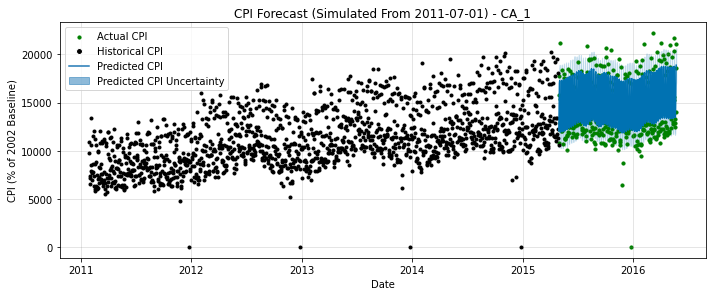

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


mse     2.584260e+06
rmse    1.607563e+03
mae     1.162995e+03
mape    1.650021e+17
dtype: float64
Initial log joint probability = -20.9176
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3687.88   0.000317014       70.0317     0.03025           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3691.73   0.000432127       74.5139           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3692.23   0.000816636       72.6226           1           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     321       3692.26   5.94686e-05       61.5739   6.788e-07       0.001      486  LS failed, Hessian reset 
     399       3692.47   1.95475e-05       49.3516      0.7359      0.7359      587   
    Iter      log prob        ||d

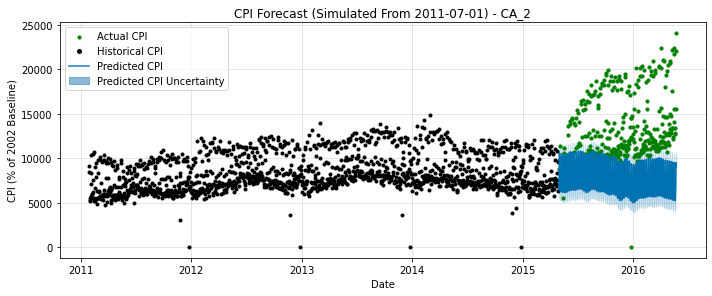

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


mse     3.828249e+07
rmse    6.187285e+03
mae     5.576639e+03
mape    5.205323e+00
dtype: float64
Initial log joint probability = -19.9418
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3512.5    0.00288168       133.752      0.3076           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3516.95   9.18731e-05       73.6479      0.4198      0.4198      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3517.86   1.59551e-05       49.1365     0.01226           1      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       3517.91   0.000125477       69.9621   2.074e-06       0.001      472  LS failed, Hessian reset 
     399       3518.11    0.00363515       105.567           1           1      565   
    Iter      log prob        ||d

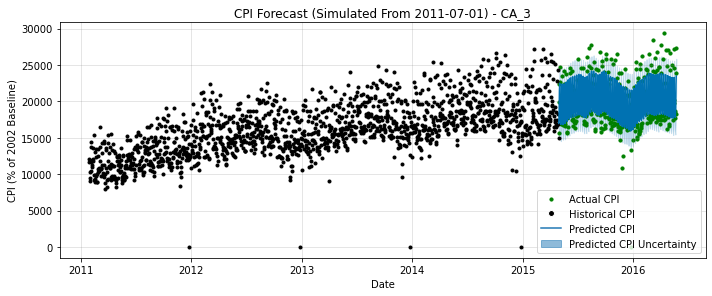

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


mse     3.609521e+06
rmse    1.899874e+03
mae     1.353236e+03
mape    5.631738e+00
dtype: float64
Initial log joint probability = -13.0364
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3569.62    0.00104219       139.901      0.5491      0.5491      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       3572.48   0.000272088       154.979   2.032e-06       0.001      254  LS failed, Hessian reset 
     199       3572.86   0.000876398       131.539       0.401       0.401      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     249       3573.06   0.000272708       156.278   3.415e-06       0.001      375  LS failed, Hessian reset 
     284       3573.09     9.705e-06       49.9241   1.282e-07       0.001      461  LS failed, Hessian reset 
     299       3573.09   1.34191e-07       65.6529      0.2136      0.2136   

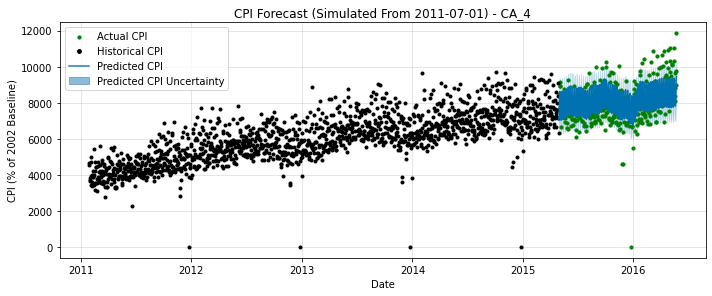

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


mse     5.820818e+05
rmse    7.629429e+02
mae     5.215213e+02
mape    8.403054e+16
dtype: float64
Initial log joint probability = -12.3867
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3569.67    0.00297135       316.846      0.3475      0.3475      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3573.08    0.00088588       105.213           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       3574.02    0.00210574       164.179   2.151e-05       0.001      302  LS failed, Hessian reset 
     299       3574.71   0.000412031       82.5691           1           1      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       3574.96   0.000139983       99.3349   1.055e-06       0.001      494  LS failed, Hessian reset 
     399 

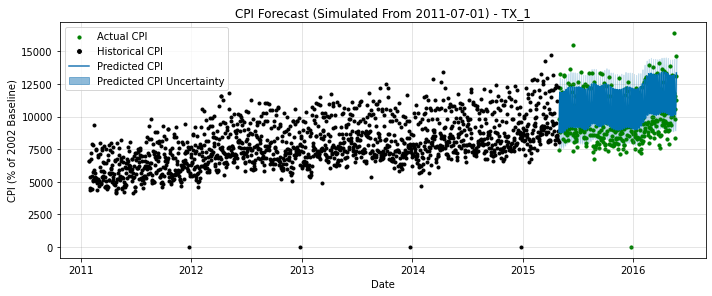

mse     1.431882e+06
rmse    1.196613e+03
mae     8.829307e+02
mape    1.591274e+01
dtype: float64


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -15.7306
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3553.46     0.0161989       336.189           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3558.5   0.000195006       94.1896      0.6139      0.6139      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       3559.41   0.000981856       106.134   1.152e-05       0.001      306  LS failed, Hessian reset 
     299        3560.5    0.00159859        99.497        2.03       0.203      414   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       3560.64   0.000422423       143.688   7.033e-06       0.001      465  LS failed, Hessian reset 
     399        3561.3   0.000228916       56.9081           1           1      573   
    Iter      log pro

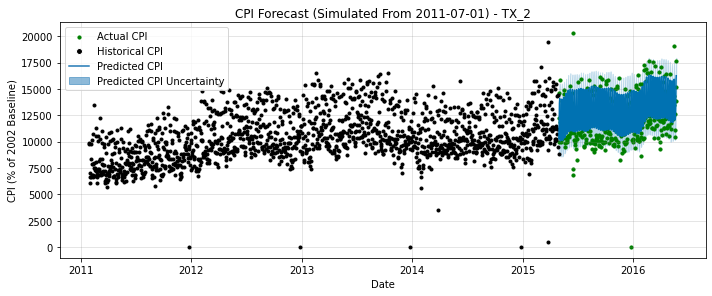

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


mse     1.955115e+06
rmse    1.398254e+03
mae     9.736597e+02
mape    1.396310e+17
dtype: float64
Initial log joint probability = -10.1919
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3620.33    0.00755932       334.483      0.3539           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3624.88   0.000160379       44.1386           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       3624.91   3.02761e-05       61.1059   5.043e-07       0.001      336  LS failed, Hessian reset 
     245       3624.91   1.56809e-08       42.8735     0.05024           1      365   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


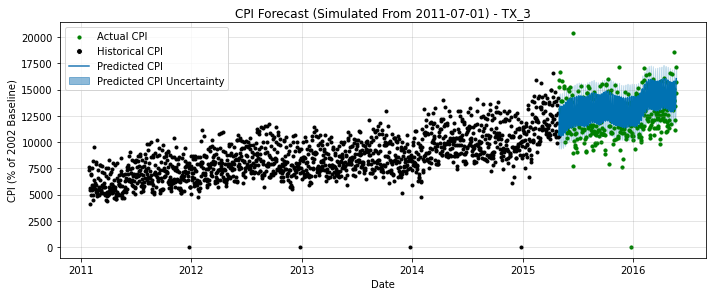

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


mse     2.589589e+06
rmse    1.609220e+03
mae     1.174867e+03
mape    2.959283e+00
dtype: float64
Initial log joint probability = -13.2978
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3632.08   0.000853671       83.7821           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       3633.19   0.000193308       88.1807   6.898e-07       0.001      213  LS failed, Hessian reset 
     165       3633.47   0.000211678       110.268   2.426e-06       0.001      291  LS failed, Hessian reset 
     190       3633.49   2.15046e-05       63.3462   2.663e-07       0.001      359  LS failed, Hessian reset 
     199       3633.49   1.05217e-06         70.27      0.4567      0.4567      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       3633.49   1.86204e-06       66.8935   2.655e-08       0.001   

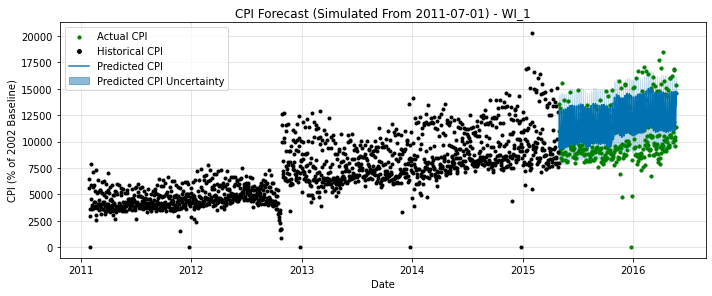

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


mse     2.800173e+06
rmse    1.673372e+03
mae     1.284564e+03
mape    8.735614e+00
dtype: float64
Initial log joint probability = -29.7834
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2771.45    0.00249103       64.5124      0.2711           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       2773.08   0.000586209       134.397    2.57e-06       0.001      206  LS failed, Hessian reset 
     190       2774.19   0.000816228       86.4982   8.715e-06       0.001      320  LS failed, Hessian reset 
     199       2774.22   1.09349e-05       55.5437      0.2551           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       2774.24   0.000120272         74.96   1.656e-06       0.001      478  LS failed, Hessian reset 
     299       2774.25   7.44083e-08       65.0357      0.2265      0.2265   

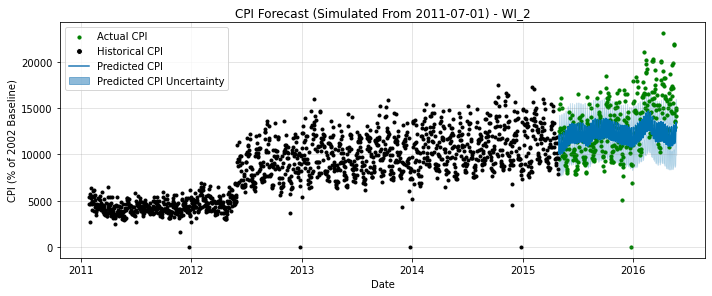

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


mse     9.394175e+06
rmse    3.064992e+03
mae     2.379476e+03
mape    2.397886e+01
dtype: float64
Initial log joint probability = -20.4702
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2959.24    0.00735906         130.7       0.635       0.635      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       2966.14     0.0050203        224.42   6.759e-05       0.001      235  LS failed, Hessian reset 
     196       2967.39   0.000372392       118.852   3.677e-06       0.001      322  LS failed, Hessian reset 
     199       2967.47   0.000350958       61.6928      0.4452      0.4452      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     289       2968.15   3.92777e-06       59.3709   5.619e-08       0.001      478  LS failed, Hessian reset 
     299       2968.15   1.17227e-06       63.1434      0.6463      0.6463   

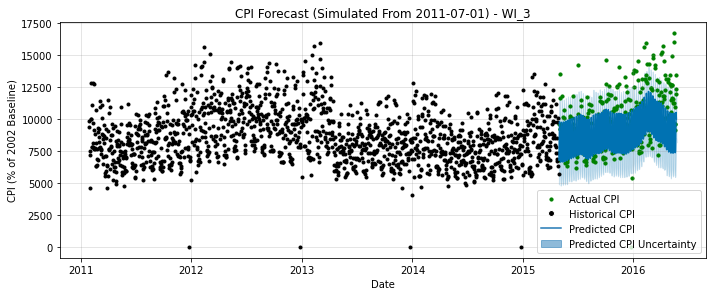

mse     3.713792e+06
rmse    1.927120e+03
mae     1.483331e+03
mape    1.499100e+01
dtype: float64


In [104]:
all_valid_metrics = {}
all_forecasts = {}
store_ids = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
for store_id in store_ids:
    
    """
    Iterate over each of the food price categories.
    """

    annual_valid_metrics = {}
    annual_forecasts = {}

#     for date in cutoff_dates:
        
#         """
#         Iterate over each of the cutoff dates. 
#         """

#     train_dates = sim_train_dates[date]
#     valid_dates = sim_valid_dates[date]

    model, valid_forecast, valid_metrics = fit_eval_forecast_model(store_id, train_df, test_df)
    valid_actual = get_prophet_df(test_df, store_id) 

    plot_valid_forecast(model, store_id, valid_forecast, valid_actual)
    valid_metrics_series = pd.Series(valid_metrics)
    print(valid_metrics_series)

    annual_valid_metrics[date] = valid_metrics_series
    annual_forecasts[date] = valid_forecast.yhat

    all_valid_metrics[store_id] = annual_valid_metrics
    all_forecasts[store_id] = annual_forecasts